# Определение перспективного тарифа для телеком-компании

## Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей


**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

## Описание данных

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Ход работы

1. Получение данных и первичный осмотр данных.
2. Предобработка данных: 
* Приведение данных к нужным типам. 
* Исправление, удаление данных. 
3. Подсчет метрик: 
* количество сделанных звонков и израсходованных минут разговора по месяцам; 
* количество отправленных сообщений по месяцам; 
* объем израсходованного интернет-трафика по месяцам; 
* помесячную выручку с каждого пользователя.
4. Исследовательский анализ: 
* Подсчет: среднее количество, дисперсию и стандартное отклонение. 
* Построение гистограммы. Описание распределения.
5. Проверка гипотез. 
6. Общие выводы по проекту. Примечание


## Импорт библиотек и подготовка файлов

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math
import copy

In [2]:
#названия для датасетов берем из названия корневой папки
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
#проверяем работоспособность всех таблиц
pd.set_option('display.max_columns', 50) #вывод всех столбцов датасета
display('calls')
display(calls.head(3))
display('internet')
display(internet.head(3))
display('messages')
display(messages.head(3))
display('tariffs')
display(tariffs.head(3))
display('users')
display(users.head(3))

'calls'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


'internet'

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


'messages'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


'tariffs'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


'users'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


In [4]:
#получим краткую информацию по каждому датасету
display('calls')
display(calls.info()) #основная информация о датасете calls
display(calls.describe()) #краткая информация о датасете calls
display('internet')
display(internet.info()) #основная информация о датасете internet
display(internet.describe()) #краткая информация о датасете internet
display('messages')
display(messages.info()) #основная информация о датасете messages
display(messages.describe()) #краткая информация о датасете messages
display('tariffs')
display(tariffs.info()) #основная информация о датасете tariffs
display(tariffs.describe()) #краткая информация о датасете tariffs
display('users')
display(users.info()) #основная информация о датасете users
display(users.describe()) #краткая информация о датасете users

'calls'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


'internet'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


'messages'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


'tariffs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


'users'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


'исходный график'

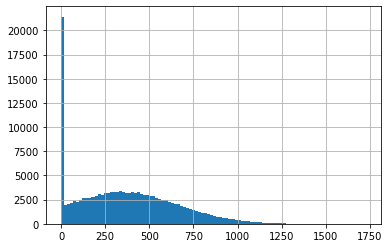

'графики без значения 0.0'

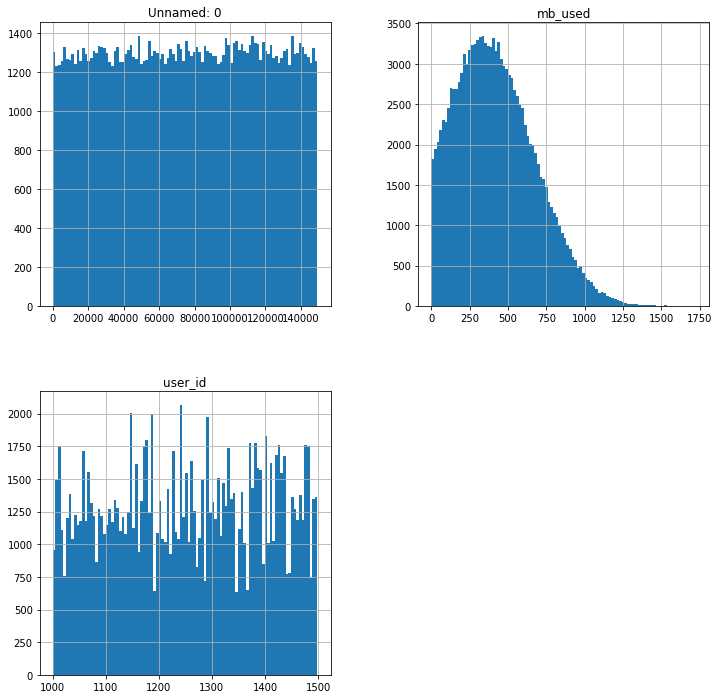

In [5]:
display('исходный график')
internet['mb_used'].hist(bins=100) 
plt.show()

display('графики без значения 0.0')
internet.query('mb_used > 0.0').hist(
    bins=100, 
    figsize = (12,12));

In [6]:
cross = list(set(calls.user_id) 
             & set(internet.user_id) 
             & set(messages.user_id) 
             & set(users.user_id))
display('Кол-во уникальных польз. в таблице calls',
len(calls.user_id.unique()))
display('Кол-во уникальных польз. в таблице internet',
len(internet.user_id.unique()))
display('Кол-во уникальных польз. в таблице messages',
len(messages.user_id.unique()))
display('Кол-во уникальных польз. в таблице users',
len(users.user_id.unique()))
display('уникальность пересечения значений первичных ключей (user_id) между объединяемыми таблицами',
len(cross))

'Кол-во уникальных польз. в таблице calls'

492

'Кол-во уникальных польз. в таблице internet'

497

'Кол-во уникальных польз. в таблице messages'

426

'Кол-во уникальных польз. в таблице users'

500

'уникальность пересечения значений первичных ключей (user_id) между объединяемыми таблицами'

419

### Вывод

Многие столбцы не соответсвуют нужным форматам, в основном это столбцы с датами. 

## Приведём файлы к нужным форматам

### calls

In [7]:
#колонку с датой переведем в нужный формат
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')


#ИСПРАВЛЕНИЕ
calls.duration = np.ceil(calls['duration']).astype('int')
#проверка
display(calls.duration)

#создадим столбец с месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

In [8]:
#проверим изменения
calls.info()
calls.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6


### internet

In [9]:
#колонку с датой переведем в нужный формат
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#создадим столбец с месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet['month']


0         11
1          9
2          6
3          8
4          9
          ..
149391    10
149392    12
149393    10
149394    11
149395    10
Name: month, Length: 149396, dtype: int64

In [10]:
#проверим изменения
internet.info()
internet.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6


### messages

In [11]:
#приведем даты к соотвествующему типу данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#создадим доп столбец с месяцем
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [12]:
#проверим изменения
messages.info()
messages.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8


### tariffs

In [13]:

#данная таблица не нуждается в адаптации 

#создаем новый столбец с идентификацией тарифа
def tariff_id(object):
    if object == 'smart':
        return 0
    elif object == 'ultra':
        return 1
tariffs['tariff_id'] = tariffs['tariff_name'].apply(tariff_id)

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,tariff_id
0,50,15360,500,550,200,3,3,smart,0
1,1000,30720,3000,1950,150,1,1,ultra,1


### users

In [14]:
#приведем даты к соотвествующему типу данных
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

#создаем новый столбец с идентификацией тарифа
def tariff_id(object):
    if object == 'smart':
        return 0
    elif object == 'ultra':
        return 1
users['tariff_id'] = users['tariff'].apply(tariff_id)

In [15]:
#проверим изменения
users.info()
users.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
 8   tariff_id   500 non-null    int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0


### Группировка таблиц

#### сообщения

In [16]:
messages_group = messages.groupby(['user_id','month']).agg(
    messages = ('id', 'count')
).reset_index()
messages_group.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### звонки

In [17]:
calls_group = calls.groupby(['user_id','month']).agg(
        calls_duration = pd.NamedAgg(column = 'duration', aggfunc = 'sum'),
        calls_number = ( 'id', 'count'),
    ).reset_index()
calls.head(10)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


#### интернет

In [18]:
internet_group = internet.groupby(
    ['user_id','month']).agg(
    {'id': 'count', 'mb_used': 'sum'}).reset_index()
internet_group.head()

,user_id,month,id,mb_used
0,1000,5,5,2253.49
1,1000,6,49,23233.77
2,1000,7,29,14003.64
3,1000,8,29,14055.93
4,1000,9,27,14568.91


### Объединение данных

In [19]:
merge_data = calls_group.merge(
    messages_group, how='outer', on=['user_id', 'month'])

merge_data = merge_data.merge(
    internet_group, how='outer', on=['user_id', 'month'])

merge_data = merge_data.merge(
    users, how='outer', on=['user_id'])

merge_data = merge_data.merge(
    tariffs, how='outer', on=['tariff_id'])

del(merge_data['tariff_name']) 
#удаляем столбец tariff_name,
#так как название тарифа у нас уже есть в колонке tariff
merge_data

,user_id,month,calls_duration,calls_number,messages,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,22.0,5.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,60.0,49.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,75.0,29.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,81.0,29.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,57.0,27.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,NaN,32.0,63.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3
3212,1489,10.0,NaN,NaN,21.0,63.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3
3213,1489,11.0,NaN,NaN,20.0,55.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3
3214,1489,12.0,NaN,NaN,35.0,51.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3


In [20]:
len(merge_data.user_id.unique())

500

никого не потеряли, все гуд

Проверка на пропуски и дубликаты

In [21]:
display('calls')
display('#количество пропусков в датасете',
        calls.isna().sum()) #количество пропусков в датасете
display('#кол-во явных дубликатов',
        calls.duplicated().sum()) #кол-во явных дубликатов
display('internet')
display('#количество пропусков в датасете',
        internet.isna().sum()) #количество пропусков в датасете
display('#кол-во явных дубликатов',
        internet.duplicated().sum()) #кол-во явных дубликатов
display('messages')
display('#количество пропусков в датасете',
        messages.isna().sum()) #количество пропусков в датасете
display('#кол-во явных дубликатов',
        messages.duplicated().sum()) #кол-во явных дубликатов
display('users')
display('#количество пропусков в датасете',
        users.isna().sum()) #количество пропусков в датасете
display('#процент пропусков от всего датасета',
        users.isna().mean().sort_values(ascending=False)*100) #процент пропусков от всего датасета
display('#кол-во явных дубликатов',
        users.duplicated().sum()) #кол-во явных дубликатов

'calls'

'#количество пропусков в датасете'

id           0
call_date    0
duration     0
user_id      0
month        0
dtype: int64

'#кол-во явных дубликатов'

0

'internet'

'#количество пропусков в датасете'

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
month           0
dtype: int64

'#кол-во явных дубликатов'

0

'messages'

'#количество пропусков в датасете'

id              0
message_date    0
user_id         0
month           0
dtype: int64

'#кол-во явных дубликатов'

0

'users'

'#количество пропусков в датасете'

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
tariff_id       0
dtype: int64

'#процент пропусков от всего датасета'

churn_date    92.4
user_id        0.0
age            0.0
city           0.0
first_name     0.0
last_name      0.0
reg_date       0.0
tariff         0.0
tariff_id      0.0
dtype: float64

'#кол-во явных дубликатов'

0

#### Вывод

Столбцы переведены в нужные форматы, добавлены столбцы с месяцами для дальнейших задач. Пропуски имеются в таблице users, это означает, что тариф ещё действовал на момент выгрузки данных у 462 пользователей, что составляет 92,4% от общего датасета. 

In [22]:
merge_data.head()

,user_id,month,calls_duration,calls_number,messages,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,22.0,5.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,60.0,49.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,75.0,29.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,81.0,29.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,57.0,27.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1


## Расчет выручки

In [23]:
merge_data['gb_used'] = merge_data['mb_used']/1024
merge_data['traffic'] = np.ceil(merge_data['gb_used'])
merge_data

,user_id,month,calls_duration,calls_number,messages,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,traffic
0,1000,5.0,159.0,22.0,22.0,5.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1,2.200674,3.0
1,1000,6.0,172.0,43.0,60.0,49.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1,22.689229,23.0
2,1000,7.0,340.0,47.0,75.0,29.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1,13.675430,14.0
3,1000,8.0,408.0,52.0,81.0,29.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1,13.726494,14.0
4,1000,9.0,466.0,58.0,57.0,27.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1,14.227451,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,NaN,32.0,63.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3,16.803027,17.0
3212,1489,10.0,NaN,NaN,21.0,63.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3,19.101016,20.0
3213,1489,11.0,NaN,NaN,20.0,55.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3,17.081602,18.0
3214,1489,12.0,NaN,NaN,35.0,51.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0,50,15360,500,550,200,3,3,16.916514,17.0


In [24]:
#функция для расчета месячного дохода для каждого клиента
def calculate(row):
    expenses = row.rub_monthly_fee
    if (row.messages > row.messages_included):
        expenses += (row.messages - row.messages_included)*row.rub_per_message
    if (row.calls_duration > row.minutes_included):
        expenses += (row.calls_duration - row.minutes_included)*row.rub_per_minute
    if (row.traffic > row.mb_per_month_included / 1024):
        expenses += (row.traffic - row.mb_per_month_included/1024)*row.rub_per_gb
    return round(expenses,2)

In [25]:
merge_data['expenses'] = merge_data.apply(calculate, axis=1)
merge_data.sample(5)

,user_id,month,calls_duration,calls_number,messages,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,traffic,expenses
2206,1264,12.0,444.0,56.0,16.0,54.0,16702.27,47,NaT,Хабаровск,Саида,Жукова,2018-04-22,smart,0,50,15360,500,550,200,3,3,16.310811,17.0,950.0
1685,1155,1.0,337.0,44.0,48.0,64.0,20125.87,71,NaT,Ставрополь,Александр,Чернов,2018-01-02,smart,0,50,15360,500,550,200,3,3,19.654170,20.0,1550.0
1517,1116,11.0,288.0,41.0,NaN,61.0,19815.51,65,NaT,Петрозаводск,Альберта,Шевцова,2018-04-17,smart,0,50,15360,500,550,200,3,3,19.351084,20.0,1550.0
545,1325,8.0,575.0,79.0,19.0,46.0,25508.19,63,NaT,Новосибирск,Артём,Федосеев,2018-06-12,ultra,1,1000,30720,3000,1950,150,1,1,24.910342,25.0,1950.0
1181,1041,11.0,12.0,5.0,NaN,11.0,2292.03,58,NaT,Москва,Михаил,Кравцов,2018-11-29,smart,0,50,15360,500,550,200,3,3,2.238311,3.0,550.0


Все подсчеты сходятся. 

In [26]:
# check
merge_data['expenses'].sum()

4916951.0

In [27]:
optimal_table = merge_data[['user_id', 
                            'month', 
                            'calls_duration', 
                            'calls_number',
                            'messages', 
                            'traffic', 
                            'tariff',
                            'city', 
                            'tariff_id', 
                            'messages_included', 
                            'mb_per_month_included',
                            'minutes_included',
                            'rub_monthly_fee',
                            'rub_per_gb',
                            'rub_per_message', 
                            'rub_per_minute',
                            'expenses']]
optimal_table
#номер клиента / месяц / вид услуги(мин, смс, гб) / тариф / город /
#условия тарифа (несколько колонок) / выручка за месяц

,user_id,month,calls_duration,calls_number,messages,traffic,tariff,city,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,expenses
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,NaN,32.0,17.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,950.0
3212,1489,10.0,NaN,NaN,21.0,20.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,1550.0
3213,1489,11.0,NaN,NaN,20.0,18.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,1150.0
3214,1489,12.0,NaN,NaN,35.0,17.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,950.0


проверяем работоспособность функций и смотрим подсчеты 

In [36]:
#создадим две таблицы по тарифам
smart = optimal_table[optimal_table['tariff_id'] == 0]
ultra = optimal_table[optimal_table['tariff_id'] == 1]
display('Количество операций пользователей тарифа Smart:',len(smart))
display('Количество операций пользователей тарифа Ultra:',len(ultra))

'Количество операций пользователей тарифа Smart:'

2230

'Количество операций пользователей тарифа Ultra:'

986

In [37]:
# check
optimal_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   float64
 2   calls_duration         3174 non-null   float64
 3   calls_number           3174 non-null   float64
 4   messages               2717 non-null   float64
 5   traffic                3203 non-null   float64
 6   tariff                 3216 non-null   object 
 7   city                   3216 non-null   object 
 8   tariff_id              3216 non-null   int64  
 9   messages_included      3216 non-null   int64  
 10  mb_per_month_included  3216 non-null   int64  
 11  minutes_included       3216 non-null   int64  
 12  rub_monthly_fee        3216 non-null   int64  
 13  rub_per_gb             3216 non-null   int64  
 14  rub_per_message        3216 non-null   int64  
 15  rub_

In [38]:
display(smart)
display(ultra)

,user_id,month,calls_duration,calls_number,messages,traffic,tariff,city,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,expenses
986,1001,11.0,430.0,59.0,NaN,18.0,smart,Москва,0,50,15360,500,550,200,3,3,1150.0
987,1001,12.0,414.0,63.0,NaN,14.0,smart,Москва,0,50,15360,500,550,200,3,3,550.0
988,1002,6.0,117.0,15.0,4.0,11.0,smart,Стерлитамак,0,50,15360,500,550,200,3,3,550.0
989,1002,7.0,214.0,26.0,11.0,18.0,smart,Стерлитамак,0,50,15360,500,550,200,3,3,1150.0
990,1002,8.0,289.0,42.0,13.0,20.0,smart,Стерлитамак,0,50,15360,500,550,200,3,3,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,NaN,32.0,17.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,950.0
3212,1489,10.0,NaN,NaN,21.0,20.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,1550.0
3213,1489,11.0,NaN,NaN,20.0,18.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,1150.0
3214,1489,12.0,NaN,NaN,35.0,17.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,950.0


,user_id,month,calls_duration,calls_number,messages,traffic,tariff,city,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,expenses
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,1473,9.0,NaN,NaN,19.0,17.0,ultra,Красноярск,1,1000,30720,3000,1950,150,1,1,1950.0
982,1473,10.0,NaN,NaN,20.0,14.0,ultra,Красноярск,1,1000,30720,3000,1950,150,1,1,1950.0
983,1473,11.0,NaN,NaN,14.0,22.0,ultra,Красноярск,1,1000,30720,3000,1950,150,1,1,1950.0
984,1473,12.0,NaN,NaN,20.0,18.0,ultra,Красноярск,1,1000,30720,3000,1950,150,1,1,1950.0


In [39]:
#функция для расчета поведения клиентов
def hist_maker_and_table(df, name,x_1_smart,x_2_ultra):
    cd = df.groupby(df.tariff)[name]
    cd_desc = cd.describe(percentiles = [.01,.25,.75,.99])
    cd_desc['var']= [np.var(cd.get_group('smart'), ddof=1), np.var(cd.get_group('ultra'), ddof=1)]
    display(cd_desc)
    smart = df.query('tariff == "smart"')[name]
    ultra = df.query('tariff == "ultra"')[name]
    plt.figure(figsize=(10,6))
    plt.hist(smart, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'smart', density = False)
    plt.hist(ultra, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'ultra', density = False)
    plt.axvline(cd_desc['mean'][0], color='blue', linestyle='dashed', linewidth=3, label='Mean smart: {:.2f}'.format(cd_desc['mean'][0]))
    
    plt.axvline(cd_desc['mean'][1], color='orange', linestyle='dashed', linewidth=3, label='Mean ultra: {:.2f}'.format(cd_desc['mean'][1]))

    plt.axvline(x_1_smart, color='blue', linestyle='solid', linewidth=3, label='Included in tariff smart')
    plt.axvline(x_2_ultra, color='orange', linestyle='solid', linewidth=3, label='Included in tariff ultra')
    plt.legend()
    plt.title('Histogramm {}'.format(name))

## Сравнение тарифов

### Звонки

СРАВНЕНИЕ ТАРИФА ULTRA И SMART


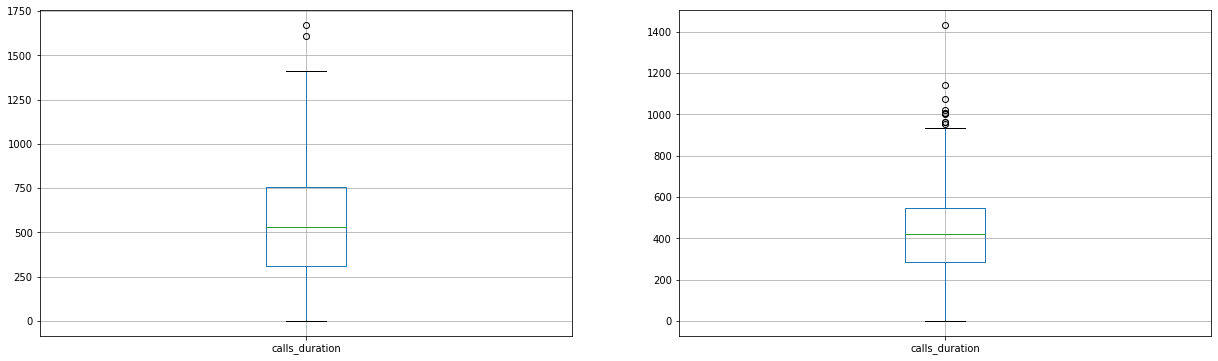

In [40]:
print('СРАВНЕНИЕ ТАРИФА ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
optimal_table[optimal_table['tariff'] == 'ultra'].boxplot('calls_duration', ax = plt.subplot(1,2,1))
optimal_table[optimal_table['tariff'] == 'smart'].boxplot('calls_duration', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2223.0,419.062978,189.325618,0.0,20.22,285.0,423.0,545.5,872.78,1435.0,35844.189551
ultra,951.0,545.451104,306.925754,0.0,11.50,310.0,528.0,756.5,1293.50,1673.0,94203.418396


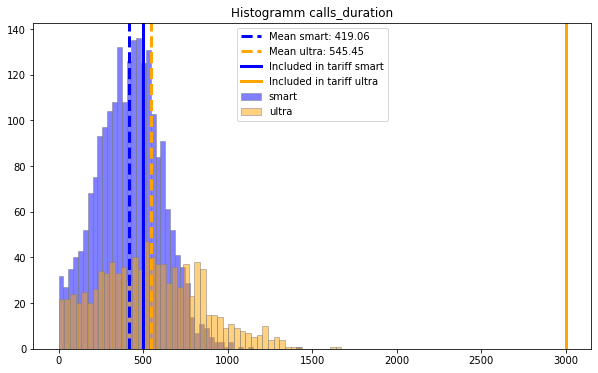

In [41]:
hist_maker_and_table(optimal_table,'calls_duration',500,3000)

#### Вывод

- Пользователи тарифа Смарт в среднем в месяц тратят меньше минут разговора, чем пользователи тарифа Ультра.
- На тарифе Смарт пользователи часто не укладываются в лимиты и доплачивают за звонки, в отличии от пользователей тарифа Ультра. 
- Дисперсия и стандартное отклонение выше на тарифе Ультра, но пользователи этого тарифа всегда укладываются в установленные лимиты. Максимальное число минут разговора в месяц значительно меньше заложенных в него 3000.

### Сообщения

СРАВНЕНИЕ ТАРИФА ULTRA И SMART


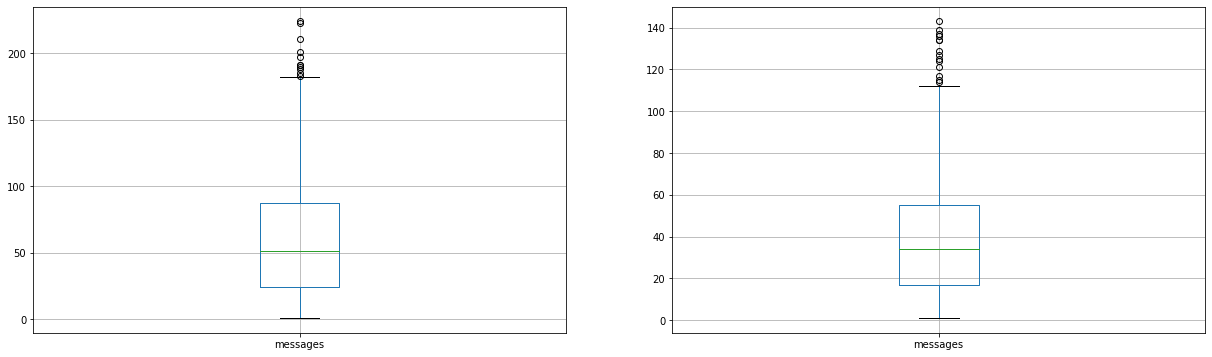

In [42]:
print('СРАВНЕНИЕ ТАРИФА ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
optimal_table[optimal_table['tariff'] == 'ultra'].boxplot('messages', ax = plt.subplot(1,2,1))
optimal_table[optimal_table['tariff'] == 'smart'].boxplot('messages', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,1922.0,38.716441,26.787949,1.0,1.0,17.0,34.0,55.0,109.00,143.0,717.594201
ultra,795.0,61.161006,45.931026,1.0,2.0,24.0,51.0,87.5,188.12,224.0,2109.659183


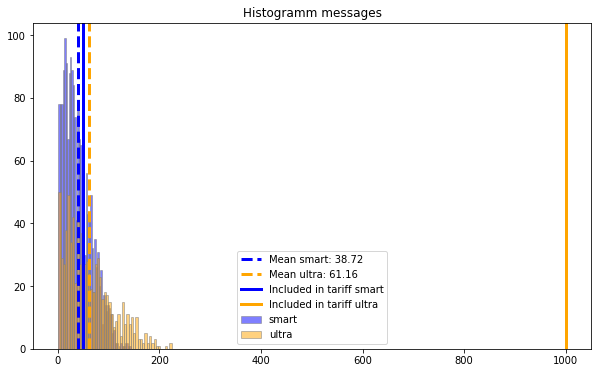

In [43]:
hist_maker_and_table(optimal_table,'messages',50,1000)

#### Вывод

- Пользователи тарифа Смарт в среднем в месяц отправляют меньше сообщений, чем пользователи тарифа Ультра.
- На тарифе Смарт пользователи иногда не укладываются в лимиты и доплачивают за сообщения, в отличии от пользователей тарифа Ультра. 
- Дисперсия и стандартное отклонение выше на тарифе Ультра, но пользователи этого тарифа всегда укладываются в установленные лимиты. Максимальное число минут разговора в месяц значительно меньше заложенных в него 1000.

### Интернет

СРАВНЕНИЕ ТАРИФА ULTRA И SMART


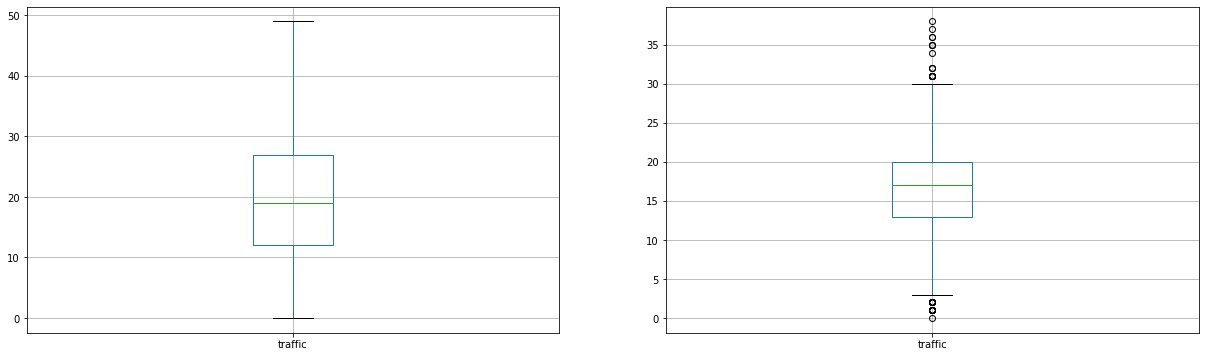

In [44]:
print('СРАВНЕНИЕ ТАРИФА ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
optimal_table[optimal_table['tariff'] == 'ultra'].boxplot('traffic', ax = plt.subplot(1,2,1))
optimal_table[optimal_table['tariff'] == 'smart'].boxplot('traffic', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2228.0,16.336176,5.737923,0.0,2.00,13.0,17.0,20.0,29.73,38.0,32.923756
ultra,975.0,19.694359,9.702924,0.0,1.74,12.0,19.0,27.0,42.26,49.0,94.146734


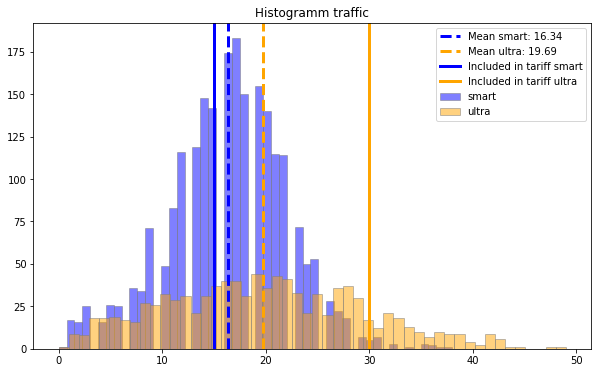

In [45]:
hist_maker_and_table(optimal_table,'traffic',15,30)

#### Вывод

- Пользователи тарифа Смарт в среднем в месяц тратят меньшее кол-во интернета, чем пользователи тарифа Ультра.
- На тарифе Смарт пользователи обычно не укладываются в лимиты и доплачивают за гигабайты. 
- Дисперсия и стандартное отклонение выше на тарифе Ультра,  пользователи этого тарифа редко не укладываются в установленные лимиты. 
- Максимальное число потраченного интернета в месяц у обоих тарифов выше заложенных. 

### Выручка

СРАВНЕНИЕ ТАРИФА ULTRA И SMART


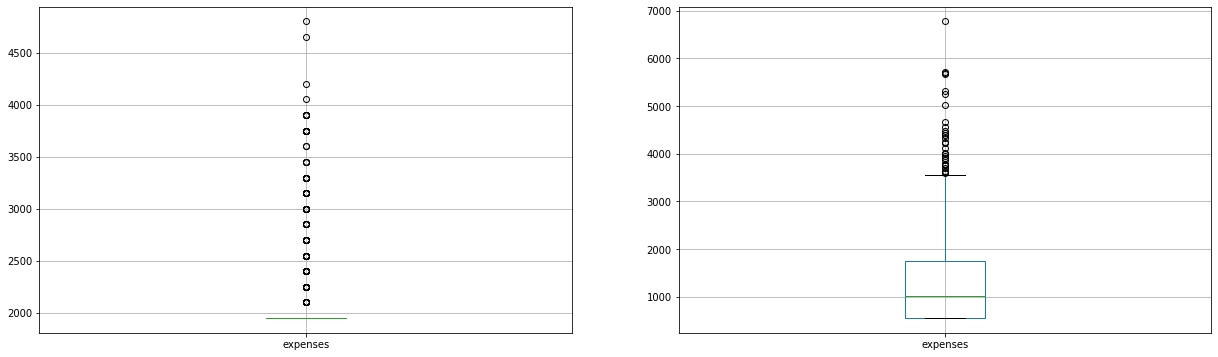

In [46]:
print('СРАВНЕНИЕ ТАРИФА ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
optimal_table[optimal_table['tariff'] == 'ultra'].boxplot('expenses', ax = plt.subplot(1,2,1))
optimal_table[optimal_table['tariff'] == 'smart'].boxplot('expenses', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,1289.641704,818.370799,550.0,550.0,550.0,1021.0,1750.0,3773.71,6770.0,669730.763895
ultra,986.0,2070.030426,376.015578,1950.0,1950.0,1950.0,1950.0,1950.0,3772.50,4800.0,141387.714809


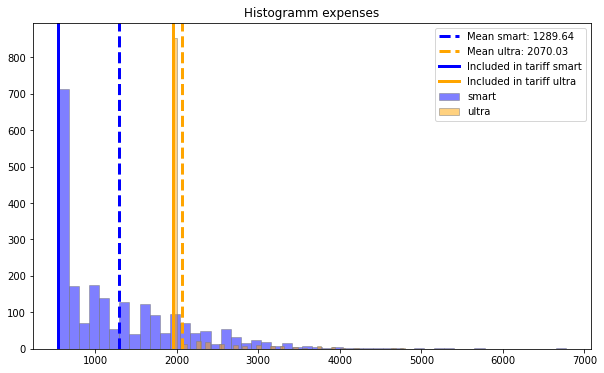

In [47]:
hist_maker_and_table(optimal_table,'expenses',550,1950)

In [48]:
display(smart.expenses.sum())
display(ultra.expenses.sum())

2875901.0

2041050.0

#### Вывод

- Средняя выручка у тарифа Ультра выше чем тарифа Смарт. 
- Стандартное отклонение и дисперсия выше у тарифа Смарт. 
- Удивляют максимальные значения за месяц, у Смарт максимальная оплата была 6770 рублей, а у Ультра 4800, что гораздо выше стоимости тарифа. 
- В среднем пользователи всегда переплачивают за пользование тарифом. 
- **В месяц в среднем тариф Ультра приносит больше денег и разумнее рекламировать его, однако из-за большого кол-ва пользователей Смарт, тариф смарт в итоге приносит больше денег**

## Гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


Нулевая гипотеза (Н0) – средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. 

Альтернативная гипотеза (Н1) – средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Для выборки необходимо взять одинаковое кол-во пользователей. 

Нам уже известно, что в данном случае дисперсии различаются, поэтому будет применен метод equal_var = False. 

Критический уровень значимости = .05

In [49]:
expenses_u = optimal_table[optimal_table['tariff'] == 'ultra']['expenses'] 
expenses_s = optimal_table[optimal_table['tariff'] == 'smart']['expenses'] 
results = st.ttest_ind( expenses_u, expenses_s)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')

p-значение:  8.081909555489933e-161
Принимаем альтернативную гипотезу


#### Вывод

Полученное значение p-value говорит о том, что средний чек пришедших из разных каналов неодинаков. Это явно слишком малая вероятность, чтобы делать вывод о незначительном различии между средними чеками.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза (Н0) – средняя выручка пользователей из Москвы и выручки пользователей из других регионов равны.  

Альтернативная гипотеза (Н1) – средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для выборки необходимо взять одинаковое кол-во пользователей. 

Пользователи из Москвы почти всегда отличаются от регионов, они чаще ведут переговоры, поэтому будет применен метод equal_var = False. 

Критический уровень значимости = .05

In [50]:
moscow = optimal_table[optimal_table['city'] == 'Москва']
other = optimal_table[optimal_table['city'] != 'Москва']
display(moscow)
display(other)

,user_id,month,calls_duration,calls_number,messages,traffic,tariff,city,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,expenses
8,1003,8.0,380.0,55.0,37.0,9.0,ultra,Москва,1,1000,30720,3000,1950,150,1,1,1950.0
9,1003,9.0,961.0,134.0,91.0,13.0,ultra,Москва,1,1000,30720,3000,1950,150,1,1,1950.0
10,1003,10.0,855.0,108.0,83.0,15.0,ultra,Москва,1,1000,30720,3000,1950,150,1,1,1950.0
11,1003,11.0,824.0,115.0,94.0,12.0,ultra,Москва,1,1000,30720,3000,1950,150,1,1,1950.0
12,1003,12.0,802.0,108.0,75.0,10.0,ultra,Москва,1,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,1490,8.0,346.0,45.0,50.0,17.0,smart,Москва,0,50,15360,500,550,200,3,3,950.0
3171,1490,9.0,322.0,44.0,48.0,15.0,smart,Москва,0,50,15360,500,550,200,3,3,550.0
3172,1490,10.0,312.0,42.0,45.0,21.0,smart,Москва,0,50,15360,500,550,200,3,3,1750.0
3173,1490,11.0,282.0,38.0,47.0,19.0,smart,Москва,0,50,15360,500,550,200,3,3,1350.0


,user_id,month,calls_duration,calls_number,messages,traffic,tariff,city,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,expenses
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,1,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,NaN,32.0,17.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,950.0
3212,1489,10.0,NaN,NaN,21.0,20.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,1550.0
3213,1489,11.0,NaN,NaN,20.0,18.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,1150.0
3214,1489,12.0,NaN,NaN,35.0,17.0,smart,Санкт-Петербург,0,50,15360,500,550,200,3,3,950.0


In [51]:
alpha = 0.05
results = st.ttest_ind(moscow['expenses'], other['expenses'], equal_var = False)
print('р-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Полученное значение p-value говорит о том, что хотя средний чек пришедших из разных каналов и неодинаков, с вероятностью в  52% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.

## Общий вывод

**Пользователи тарифа Смарт, в среднем за месяц:**

- Тратят минут разговора: **419**
- Пишут сообщений: **38**
- Используют интернета (gb): **16**


- Стандартное отклонение минут разговора: **189.32**
- Стандартное отклонение сообщений: **26.78**
- Стандартное отклонение гигабайт интернета: **5.73** 


- Дисперсия минут разговора: **35844.18**
- Дисперсия сообщений: **717.59**
- Дисперсия гигабайт интернета: **32.92**


**Пользователи тарифа Ультра, в среднем за месяц:**
 
- Тратят минут разговора: **545**
- Пишут сообщений: **61**
- Используют интернета (gb): **20**


- Стандартное отклонение минут разговора: **306.92**
- Стандартное отклонение сообщений: **45.93**
- Стандартное отклонение гигабайт интернета: **9.70**


- Дисперсия минут разговора: **94203.41**
- Дисперсия сообщений: **2109.65**
- Дисперсия гигабайт интернета: **94.14**

-------------

- Людям больше нравится пользоваться тарифом Смарт.
- Средняя выручка одного пользователя в тарифе Ультра выше Смарт'а, но большую прибыль по итогу приносит тариф Смарт. 
- В обоих случаях превышается лимит на интернет.
- Пользователи тарифа Смарт чаще выходят за рамки лимитов, причем по всем показателям.
- Пользователи тарифа Ультра превышают только лимит интернета. 
- Отвергаем гипотезу о том, что средняя выручка пользователей тарифов "Смарт" и "Ультра" равны.
- Нельзя отрицать, что средняя выручка пользователей из Москвы и выручки пользователей из других регионов равны.
- **В месяц в среднем тариф Ультра приносит больше денег и разумнее рекламировать его, однако из-за большого кол-ва пользователей Смарт, тариф смарт в итоге приносит больше денег**

## Чек-лист готовности проекта
- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()` и так далее)
- [x]  Приведите данные к нужным типам;
- [x]  Найдите и исправьте ошибки в данных, если они есть.
- [x]  количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x]  количество отправленных сообщений по месяцам;
- [x]  объем израсходованного интернет-трафика по месяцам;
- [x]  помесячную выручку с каждого пользователя 
- [x]  Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- [x]  Посчитайте среднее количество, дисперсию и стандартное отклонение.
- [x]  Постройте гистограммы. Опишите распределения.
- [x]  ГИПОТЕЗА: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- [x]  ГИПОТЕЗА: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод

## Варианты для сравнения тарифов, диаграмма размаха — основной тип графика для сравнения показателей описательной статистики

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
revenue = optimal_table.copy()

In [56]:
revenue.columns

Index(['user_id', 'month', 'calls_duration', 'calls_number', 'messages',
       'traffic', 'tariff', 'city', 'tariff_id', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'expenses'],
      dtype='object')

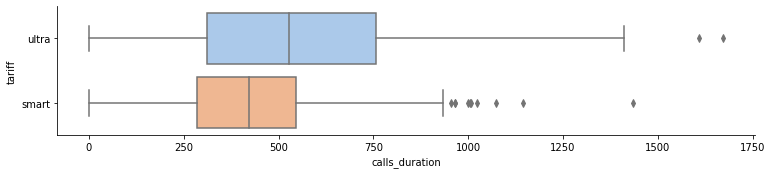

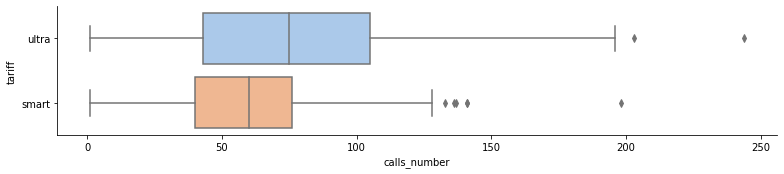

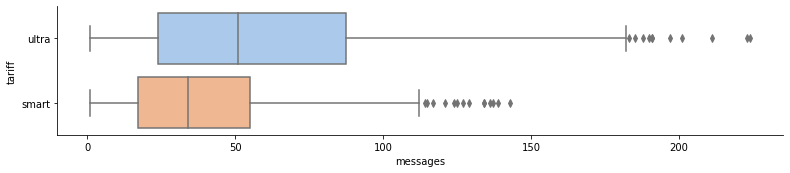

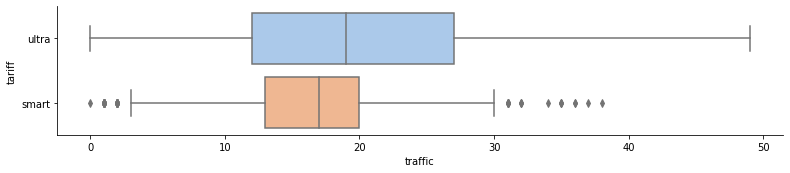

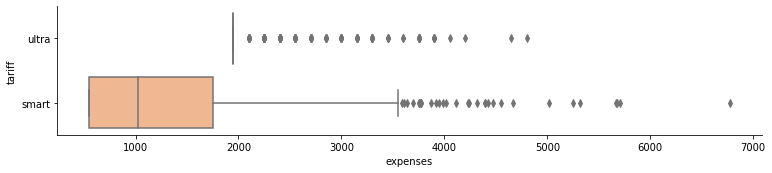

In [62]:

for column in ['calls_duration', 'calls_number', 'messages',
       'traffic', 'expenses']:    
    g = sns.catplot(y='tariff', x=column, kind="box", data= revenue, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
#    g.set(xlim=(-50, None))

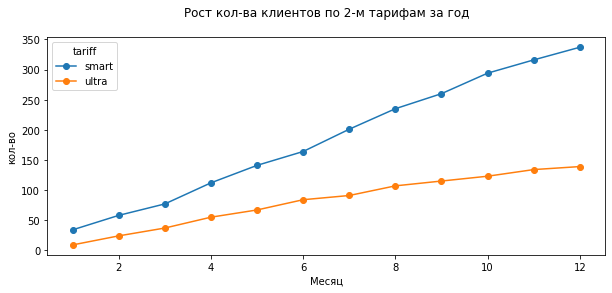

In [58]:
(revenue
 .pivot_table(index='tariff', columns='month', values='user_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Рост кол-ва клиентов по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('кол-во');

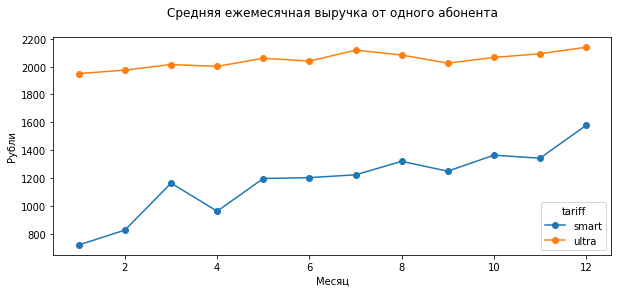

In [59]:
(revenue
 .pivot_table(index='tariff', columns='month', values='expenses', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка от одного абонента'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

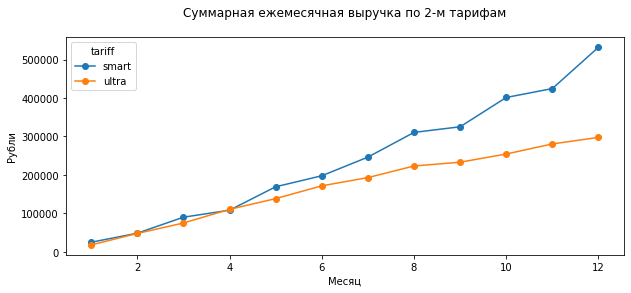

In [60]:
(revenue
 .pivot_table(index='tariff', columns='month', values='expenses', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Суммарная ежемесячная выручка по 2-м тарифам'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

# выручка от смартов уже в два раза выше выручки от ультры, но есть опасность - убегут клиенты смарт от такой счастливой жизни к конкурентам :)

In [61]:
# на скорую руку
try:
    df_users = pd.read_csv('/datasets/users.csv')
except:
    df_users = pd.read_csv('users.csv')

print ('Кол-во клентов покинувших компанию за год', df_users.churn_date.notna().sum())

print ('Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
       df_users.query('churn_date > "2018-09-25"').churn_date.notna().sum()
      )
print ('%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
    (df_users.query('churn_date > "2018-09-25"').churn_date.notna().sum()/df_users.churn_date.notna().sum()*100).round(1)
)

print ('Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.')
df_users.query('churn_date > "2018-09-25"').groupby('tariff')['churn_date'].count().to_frame()

Кол-во клентов покинувших компанию за год 38
Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 35
%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 92.1
Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.


,churn_date
tariff,
smart,22
ultra,13
